Node attributes:
Node 0: {'role': 'leecher'}
Node 1: {'role': 'leecher'}
Node 2: {'role': 'leecher'}
Node 3: {'role': 'seeder'}
Node 4: {'role': 'leecher'}
Node 5: {'role': 'leecher'}
Node 6: {'role': 'leecher'}
Node 7: {'role': 'leecher'}
Node 8: {'role': 'leecher'}
Node 9: {'role': 'leecher'}
Node 10: {'role': 'leecher'}
Node 11: {'role': 'leecher'}
Node 12: {'role': 'leecher'}
Node 13: {'role': 'leecher'}
Node 14: {'role': 'leecher'}
Node 15: {'role': 'leecher'}
Node 16: {'role': 'leecher'}
Node 17: {'role': 'leecher'}
Node 18: {'role': 'leecher'}
Node 19: {'role': 'leecher'}


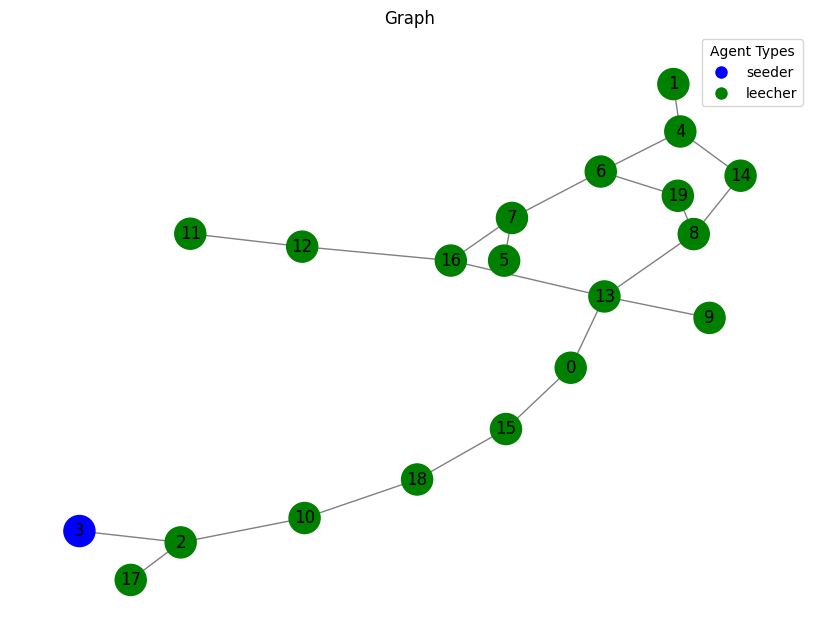


Added node 20 with agent type: leecher


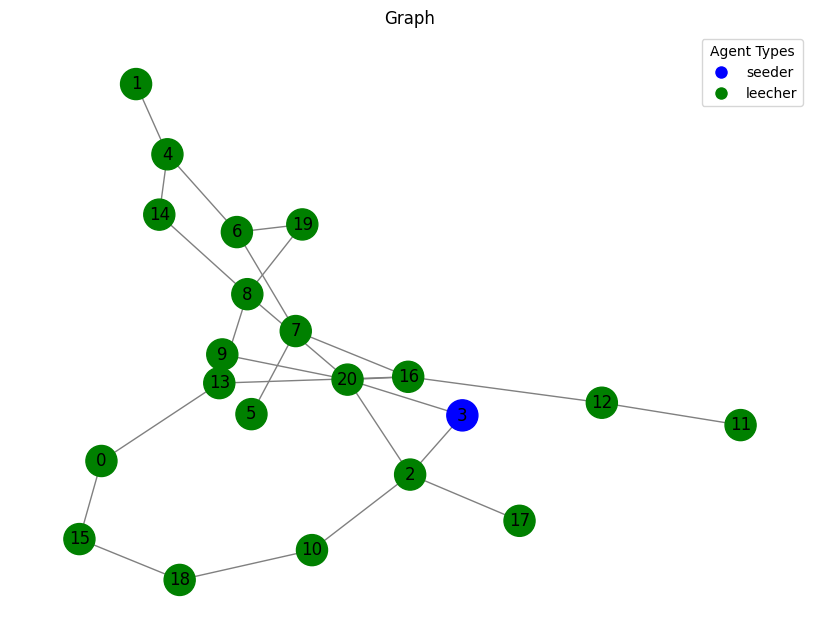

In [ ]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.graph import erdos_renyi_graph
import src.agent as agent_module
from utils.plotter import draw_graph


G = erdos_renyi_graph(n=20, p=0.1)
agent_module.assign_n_seeders(G, n=1, seed=42)
print("Node attributes:")
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")
draw_graph(G)

new_node_id, new_agent = agent_module.add_random_node(G)
print(f"\nAdded node {new_node_id} with agent type: {new_agent.agent_type}")
draw_graph(G)
